# Churn Prediction Model
This notebook trains an XGBoost-based churn model on the `churn.csv` dataset, dropping UI-only columns (`customerID`, `variant`) and outputting artifacts for deployment.

In [23]:
# Step 1: Imports
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc, confusion_matrix


In [24]:
# Step 2: Load & Clean Data
df = pd.read_csv(r'C:\Users\tanes\OneDrive\Desktop\EngageTrack-AI\data\churn.csv')  # adjust path as needed
# Drop UI-only columns
df.drop(columns=["customerID", "variant"], errors="ignore", inplace=True)
# Remove blank TotalCharges and convert
mask = df["TotalCharges"].astype(str).str.strip() != ""
df = df.loc[mask].copy()
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
df.dropna(subset=["TotalCharges"], inplace=True)
# Log-transform
df["TotalCharges"] = np.log1p(df["TotalCharges"])


In [25]:
# Step 3: Encode Target & Categoricals
# Encode Churn as 0/1
df['Churn'] = (df['Churn'] == 'Yes').astype(int)

categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
label_encoders = {}
for col in categorical_cols:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le


In [26]:
# Step 4: Split features & target
X = df.drop(columns=['Churn'])
y = df['Churn']


In [27]:
# Step 5: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [28]:
# Step 6: Feature scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


In [29]:
# Step 7: Train XGBoost with imbalance handling
ratio = (y_train == 0).sum() / (y_train == 1).sum()
model = xgb.XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=ratio,
    learning_rate=0.1,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1.0,
    reg_alpha=0.3,
    n_estimators=100,
    random_state=42
)
model.fit(X_train_scaled, y_train)


C:\Users\tanes\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [02:14:10] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, feature_weights=None, gamma=None,
              grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=4, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, ...)

In [30]:
# Step 8: Evaluate Model
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]

print("AUC:", round(roc_auc_score(y_test, y_proba), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))


AUC: 0.8344

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.72      0.80      1033
           1       0.50      0.78      0.61       374

    accuracy                           0.73      1407
   macro avg       0.70      0.75      0.70      1407
weighted avg       0.79      0.73      0.75      1407



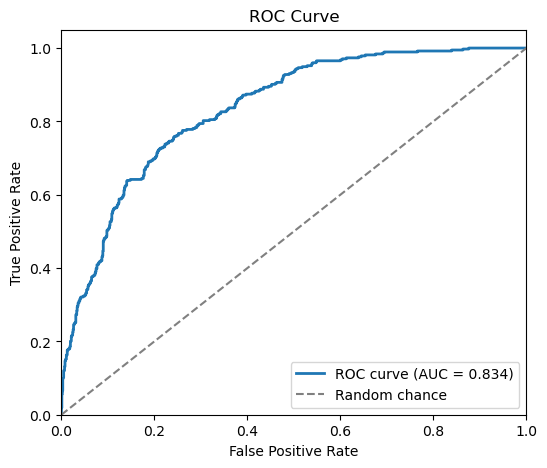

In [31]:
# Step 8.5: Plot ROC Curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(6,5))
plt.plot(fpr, tpr, lw=2, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0,1], [0,1], linestyle='--', color='gray', label='Random chance')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.show()


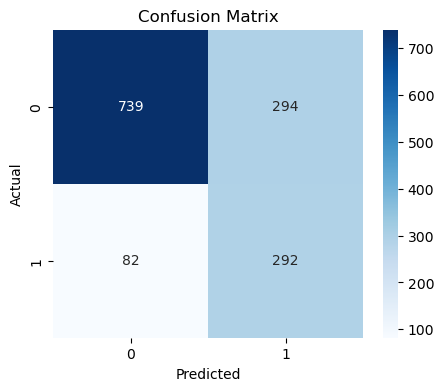

In [32]:
# Step 9: Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


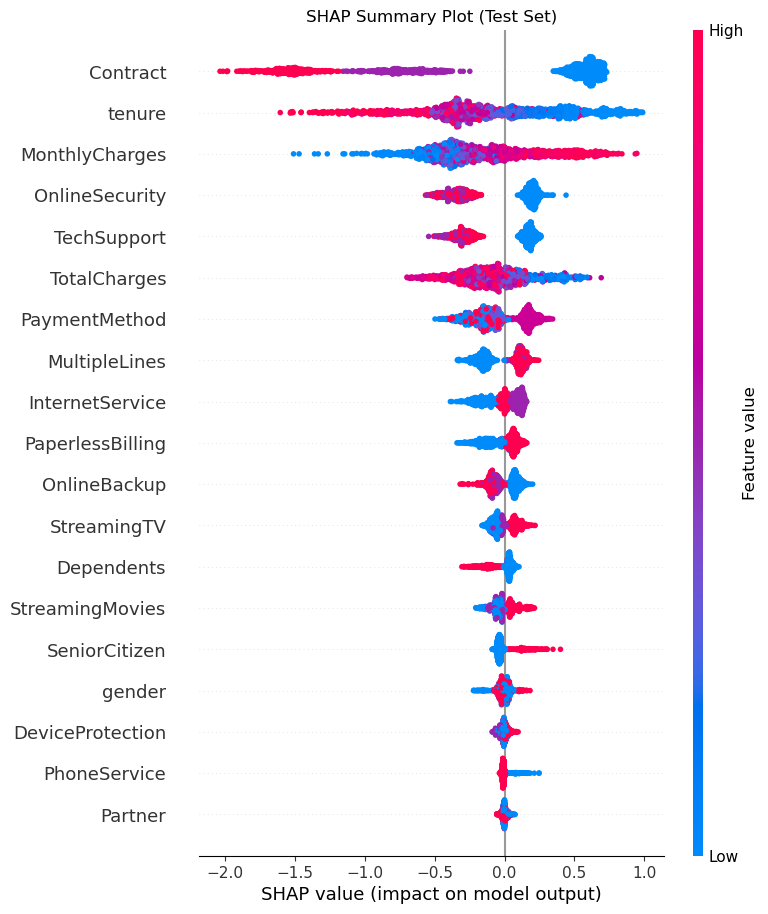

In [33]:
# Step 9.5: SHAP Explainability
import shap
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_test_scaled)
plt.figure(figsize=(8,6))
shap.summary_plot(shap_values, X_test, feature_names=X.columns, show=False)
plt.title('SHAP Summary Plot (Test Set)')
plt.show()


In [34]:
# Step 10: Save Artifacts
joblib.dump(model, 'xgb_model.pkl')
joblib.dump(scaler, 'scaler.pkl')
joblib.dump(label_encoders, 'label_encoders.pkl')
print('Artifacts saved: xgb_model.pkl, scaler.pkl, label_encoders.pkl')


Artifacts saved: xgb_model.pkl, scaler.pkl, label_encoders.pkl
